---
# Test de modeles avec toutes les variables
---

---
## 1) Lecture fichier csv
---

In [1]:
#!/usr/bin/env python
# coding: utf-8

# In[4]:


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
import seaborn as sns
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectFromModel, f_regression, mutual_info_regression, RFE, RFECV
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import StandardScaler
from urllib.request import urlopen
from bs4 import BeautifulSoup
import requests
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Lasso

whr_NoNA_all=pd.read_csv('whr_NoNA_all.csv',';',index_col=0)





---
## 2) Transformation regime politique en dummies (numerisation)
---

In [2]:
### Transformation des regimes en dummies sur DataFrame whr_NoNA_all

whr_NoNA_all=whr_NoNA_all.join(pd.get_dummies(whr_NoNA_all['Regime']))
whr_NoNA_all=whr_NoNA_all.drop('Regime',axis=1)



In [3]:
### Verification des types des variables et qu'il n'y a pas de valeurs manquantes
whr_NoNA_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1586 entries, 0 to 1585
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Country                    1586 non-null   object 
 1   Year                       1586 non-null   int64  
 2   Life Ladder                1586 non-null   float64
 3   LogGDP                     1586 non-null   float64
 4   SocialSupport              1586 non-null   float64
 5   LifeExpectancy             1586 non-null   float64
 6   Freedom                    1586 non-null   float64
 7   Generosity                 1586 non-null   float64
 8   Corruption                 1586 non-null   float64
 9   PosAffect                  1586 non-null   float64
 10  NegAffect                  1586 non-null   float64
 11  Region                     1586 non-null   object 
 12  AreaInK2                   1586 non-null   int64  
 13  Population                 1586 non-null   int64

on confirme bien qu'il n'y a pas de lignes contenant de valeurs null. De plus les variables explicatives ne sont plus en type object => on pourra donc réaliser des modélisations dessus

---
## 3) Modelisation avec les variables ajoutees
---


### a) Reduction de dimenssion PCA


#### Preparation donnees pour PCA

In [4]:
### Separation variable cible Life Ladder

life_ladder=whr_NoNA_all['Life Ladder']

### Decoupage Life Ladder en 4
#q = [0, 0.25, 0.5,0.75, 1]

life_ladder_cut = pd.qcut(life_ladder, q=4)

### DataFrame pour PCA avec variables explicatives
data_acp=whr_NoNA_all.drop(['Life Ladder','Region'],axis=1).set_index('Country')


#### Determination variance expliquee selon les axes de representation

Les ratio sont : [2.44999298e-01 9.40361900e-02 7.46078464e-02 7.20066348e-02
 6.00467558e-02 5.69840399e-02 5.03380967e-02 4.61521346e-02
 4.07622450e-02 3.61851049e-02 3.10018376e-02 2.60239215e-02
 2.32718625e-02 2.26530237e-02 1.94829171e-02 1.61550219e-02
 1.48600897e-02 1.37008553e-02 1.24778340e-02 1.09647938e-02
 8.83187001e-03 8.08313447e-03 6.76013591e-03 4.17836209e-03
 3.04910980e-03 2.38681827e-03 6.58252364e-08 4.83175921e-32]


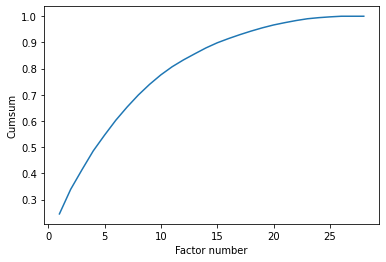

In [5]:
### Normalisation des donnees
scaler = StandardScaler()  # Création de l'instance StandardScaler
Z = scaler.fit_transform(data_acp)

### Application PCA
pca = PCA()  # Création de l'instance PCA
Coord = pca.fit_transform(Z)  # Calcul des coordonnées de l'ACP

### Calcul ration de variance expliquee
print('Les ratio sont :',pca.explained_variance_ratio_)

plt.plot(np.arange(1, 29), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Factor number')
plt.ylabel('Cumsum');


On fera les representations selon les 2 premiers axes par simplicité. 
On remarque qu'une representation sur 2 axes ne conserve qu'environ 33% de la variance expliquee. Les schémas suivant seront donc biaisés mais permettent tout de même de se donner une idée des relations entre variables et leurs influences

#### Representation des variables et pays selon les axes et valeurs de Life Ladder

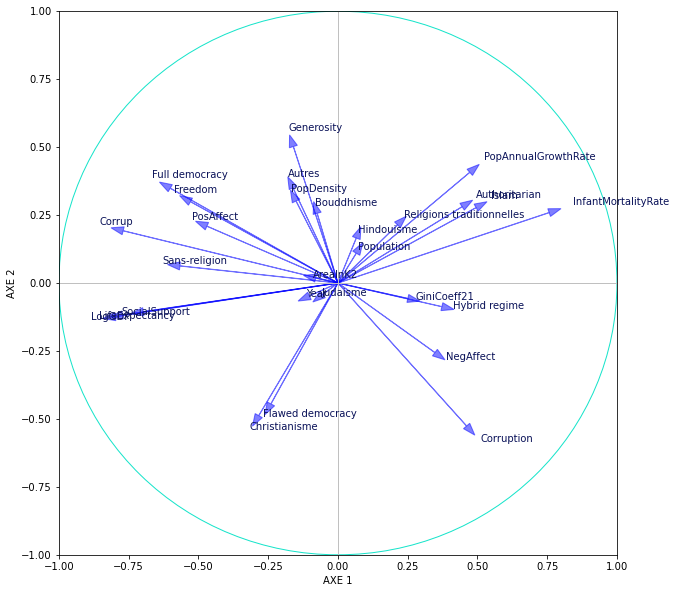

In [6]:
### Representation des variables selon les 2 premiers axes

sqrt_eigval = np.sqrt(pca.explained_variance_)
# corvar
corvar = np.zeros((28, 28))
for k in range(28):
    corvar[:, k] = pca.components_[k, :] * sqrt_eigval[k]


fig, axes = plt.subplots(figsize=(10, 10))
axes.set_xlim(-1, 1)
axes.set_ylim(-1, 1)

# affichage des étiquettes (noms des variables)
for j in range(28):
    plt.annotate(data_acp.columns[j], (corvar[j, 0], corvar[j, 1]), color='#091158')
    plt.arrow(0, 0, corvar[j, 0]*0.9, corvar[j, 1]*0.9, alpha=0.5, head_width=0.03, color='b')

# ajouter les axes
plt.plot([-1, 1], [0, 0], color='silver', linestyle='-', linewidth=1)
plt.plot([0, 0], [-1, 1], color='silver', linestyle='-', linewidth=1)

cercle = plt.Circle((0, 0), 1, color='#16E4CA', fill=False)
axes.add_artist(cercle)
plt.xlabel('AXE 1')
plt.ylabel('AXE 2')
plt.show();



On voit des variables dans les 4 cadrans avec plus ou moins d'influence => les variables ajoutées semblent donc avoir de l'influence dans l'explication du Life Ladder

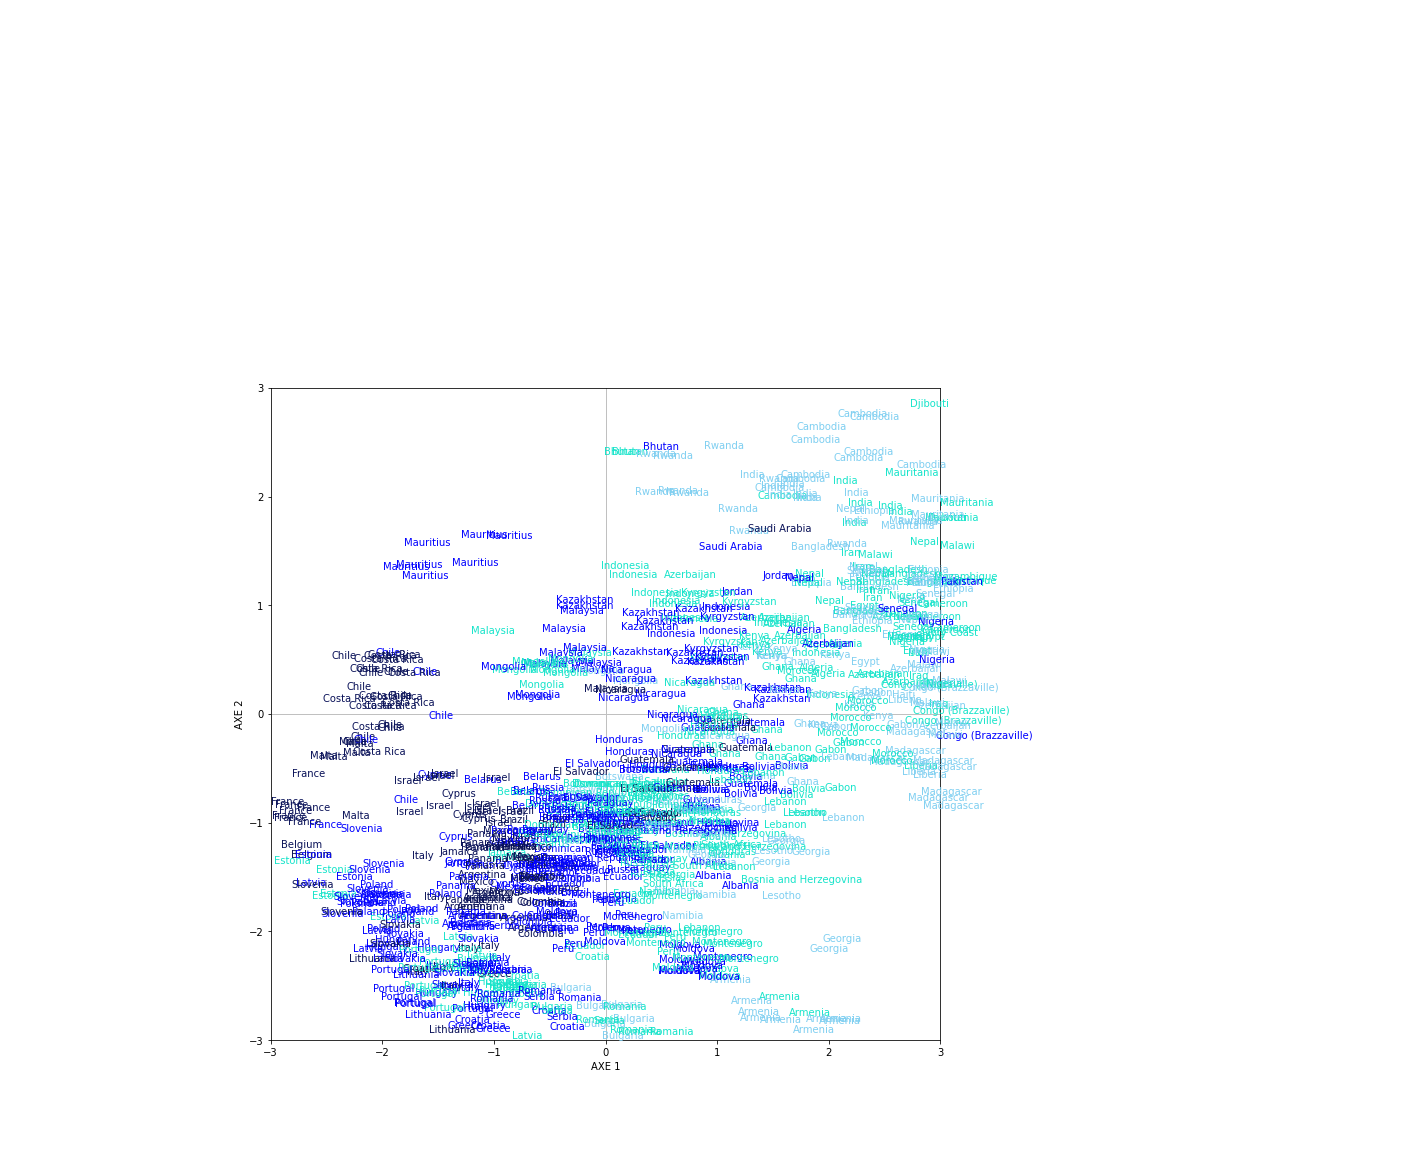

In [7]:
### Representation des pays selon les 2 premiers axes colores en fonction de la valeur de Life Ladder

fig, axes = plt.subplots(figsize=(12, 12))
axes.set_xlim(-3, 3) 
axes.set_ylim(-3, 3) 

#placement des étiquettes des observations
for i in range(1294):
    if life_ladder.iloc[i] in life_ladder_cut.cat.categories[0]:
        plt.annotate(data_acp.index[i], (Coord[i, 0],Coord[i, 1]), color='#7FCFF1')
    elif life_ladder.iloc[i] in life_ladder_cut.cat.categories[1]:
        plt.annotate(data_acp.index[i], (Coord[i, 0],Coord[i, 1]), color='#16E4CA')
    elif life_ladder.iloc[i] in life_ladder_cut.cat.categories[2]:
        plt.annotate(data_acp.index[i], (Coord[i, 0],Coord[i, 1]), color='b')
    else:
        plt.annotate(data_acp.index[i], (Coord[i, 0],Coord[i, 1]), color='#091158')
            
#ajouter les axes
plt.plot([-6, 6], [0,0], color='silver', linestyle='-', linewidth=1)
plt.plot([0, 0], [-6, 6], color='silver', linestyle='-', linewidth=1)
plt.xlabel('AXE 1')
plt.ylabel('AXE 2')
#affichage
plt.show();



On conserve une coupure en 2 des pays globalement. 
Précédemment on avait vu que les pays aux niveaux les plus faibles étaient en haut à droite et qu'il n'y avait pas de variables les expliquant parmi les premières fournies.
Cependant avec celles ajoutées, en utilisant le schéma précédent on observe que c'est essentiellemnt des considération démographiques et de régime politique qui expliquent ces faibles valeurs de Life Ladder

On voit également que les pays ayant les meilleurs taux de Life Ladder sont plus facilement décelables

### b) Application de l'Arbre de decision

#### Preparation donnees pour le modele arbre de decision (dtc)

In [8]:
### Conservation que des variables numériques
whr_NoNA_all_dtc=whr_NoNA_all.drop(['Year','Region'],axis=1)
whr_NoNA_all_dtc=whr_NoNA_all_dtc.set_index('Country')

### Separation variable cible (Life Ladder)
life_ladder_dtc=whr_NoNA_all_dtc['Life Ladder']

### Suppression de la variable cible du DataFrame servant pour l'etude
whr_NoNA_all_dtc=whr_NoNA_all_dtc.drop('Life Ladder',axis=1)

In [9]:
### Decoupage variable cible en 2 classes separees par la mediane
life_ladder_cut_dtc = pd.qcut(life_ladder_dtc, q=2,labels=[1,2])

### Decoupage variable cible en 10 classes : on arrondi les valeurs de Life Ladder => erreur de 0.5
life_ladder_cut_dix_dtc = pd.cut(life_ladder_dtc, [0,0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10],
                                 labels=[0,1,2,3,4,5,6,7,8,9,10])


#### Definition et entrainement du modele

In [10]:

### Life Ladder coupé en 2

#jeu d'entrainement et test
X_train,X_test,y_train,y_test=train_test_split(whr_NoNA_all_dtc, life_ladder_cut_dtc, test_size=0.2,random_state=123)

#definition du modele
dt_clf=DecisionTreeClassifier(criterion='entropy',max_depth=4,random_state=123)

#entrainement du modele
dt_clf.fit(X_train,y_train)

### Life Ladder coupé en 10 : arrondi

#jeu d'entrainement et test
X_train_dix,X_test_dix,y_train_dix,y_test_dix=train_test_split(whr_NoNA_all_dtc, life_ladder_cut_dix_dtc, test_size=0.2,random_state=123)

#definition du modele
dt_clf_dix=DecisionTreeClassifier(criterion='entropy',max_depth=4,random_state=123)

#entrainement du modele
dt_clf_dix.fit(X_train_dix,y_train_dix)





DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=123)

#### Determination des variables utilisees par le modele par ordre d'importance

In [11]:
### Life Ladder en 2

feats={}
for i,j in zip(whr_NoNA_all_dtc.columns,dt_clf.feature_importances_):
    feats[i]=j

importance=pd.DataFrame.from_dict(feats,orient='index')
importance=importance.rename(columns={0: 'Importance'})

importance.sort_values(by='Importance',ascending=False).head(8)



,Importance
LifeExpectancy,0.519192
LogGDP,0.196291
SocialSupport,0.168540
PosAffect,0.057323
Islam,0.026827
Sans-religion,0.019159
Generosity,0.012668
Bouddhisme,0.000000


In [12]:
### Life Ladder en 10

feats_dix={}
for i,j in zip(whr_NoNA_all_dtc.columns,dt_clf_dix.feature_importances_):
    feats_dix[i]=j

importance_dix=pd.DataFrame.from_dict(feats_dix,orient='index')
importance_dix=importance_dix.rename(columns={0: 'Importance_dix'})

importance_dix.sort_values(by='Importance_dix',ascending=False).head(8)

,Importance_dix
LifeExpectancy,0.553925
LogGDP,0.192438
SocialSupport,0.086003
PosAffect,0.039524
Judaisme,0.037843
Corruption,0.029354
Generosity,0.018166
Islam,0.016570


Ce modèle donne encore une grande importance à l'esperance de vie et au PIB

#### Performance du modele

In [13]:
### Life Ladder coupé en 2
print("le score pour 2 classes sur le jeu d'entrainement est de : ",dt_clf.score(X_train, y_train))
print("le score pour 2 classes sur le jeu de test est de : ",dt_clf.score(X_test, y_test))

### Life Ladder coupé en 10
print("le score, pour les valeurs arrondies de Life Ladder, sur le jeu d'entrainement est de : ",dt_clf_dix.score(X_train_dix, y_train_dix))
print("le score, pour les valeurs arrondies de Life Ladder, sur le jeu de test est de : ",dt_clf_dix.score(X_test_dix, y_test_dix))

le score pour 2 classes sur le jeu d'entrainement est de :  0.8777602523659306
le score pour 2 classes sur le jeu de test est de :  0.8647798742138365
le score, pour les valeurs arrondies de Life Ladder, sur le jeu d'entrainement est de :  0.6514195583596214
le score, pour les valeurs arrondies de Life Ladder, sur le jeu de test est de :  0.6320754716981132


### c) Application du modele Random Forest

#### Preparation donnees pour le modele

In [14]:
whr_NoNA_all_rf=whr_NoNA_all.drop(['Year','Region'],axis=1)
whr_NoNA_all_rf=whr_NoNA_all_rf.set_index('Country')

### Isolation variable cible
life_ladder_rf=whr_NoNA_all_rf['Life Ladder']

### Suppression variable cible
whr_NoNA_all_rf=whr_NoNA_all_rf.drop('Life Ladder',axis=1)

### Decoupage Life Ladder en 2 classes
life_ladder_cut_rf = pd.qcut(life_ladder_rf, q=2,labels=[1,2])

### Arrondi de Life Ladder => 10 classes
life_ladder_cut_dix_rf = pd.cut(life_ladder_rf, [0,0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10],
                                labels=[0,1,2,3,4,5,6,7,8,9,10])



#### Definition et entrainement du modele

In [15]:
### Life Ladder coupé en 2

#Jeu entrainement et test
X_train_rf,X_test_rf,y_train_rf,y_test_rf=train_test_split(whr_NoNA_all_rf, life_ladder_cut_rf, test_size=0.2,random_state=123)

#Definition du modele
clf_rf=RandomForestClassifier(n_jobs=-1,random_state=321)

#Entrainement du modele
clf_rf.fit(X_train_rf,y_train_rf)

### Life Ladder coupé en 10

#Jeu entrainement et test
X_train_dix_rf,X_test_dix_rf,y_train_dix_rf,y_test_dix_rf=train_test_split(whr_NoNA_all_rf, life_ladder_cut_dix_rf,test_size=0.2,random_state=123)

#Definition du modele
clf_rf_dix=RandomForestClassifier(n_jobs=-1,random_state=321)

#Entrainement du modele
clf_rf_dix.fit(X_train_dix_rf,y_train_dix_rf)

RandomForestClassifier(n_jobs=-1, random_state=321)

#### Determination des variables utilisees par le modele par ordre d'importance

In [16]:
### Life Ladder en 2

feats_rf={}
for i,j in zip(whr_NoNA_all_rf.columns,clf_rf.feature_importances_):
    feats_rf[i]=j

importance_rf=pd.DataFrame.from_dict(feats_rf,orient='index')
importance_rf=importance_rf.rename(columns={0: 'Importance'})

importance_rf.sort_values(by='Importance',ascending=False).head(20)



,Importance
LifeExpectancy,0.161196
LogGDP,0.127808
SocialSupport,0.117728
InfantMortalityRate,0.089786
PosAffect,0.069895
Corrup,0.056757
Sans-religion,0.051734
PopAnnualGrowthRate,0.042611
Islam,0.039683
Freedom,0.034979


In [17]:
### Life Ladder en 10

feats_dix_rf={}
for i,j in zip(whr_NoNA_all_rf.columns,clf_rf_dix.feature_importances_):
    feats_dix_rf[i]=j

importance_dix_rf=pd.DataFrame.from_dict(feats_dix_rf,orient='index')
importance_dix_rf=importance_dix_rf.rename(columns={0: 'Importance_dix_rf'})

importance_dix_rf.sort_values(by='Importance_dix_rf',ascending=False).head(20)

,Importance_dix_rf
LogGDP,0.113806
LifeExpectancy,0.094107
SocialSupport,0.080567
InfantMortalityRate,0.064532
Corrup,0.059593
Freedom,0.055113
PosAffect,0.054882
Corruption,0.052976
PopAnnualGrowthRate,0.051526
Population,0.043884


In [18]:
### coupé en 2
print("le score pour 2 classes sur le jeu d'entrainement est de : ",clf_rf.score(X_train_rf, y_train_rf))
print("le score pour 2 classes sur le jeu de test est de : ",clf_rf.score(X_test_rf, y_test_rf))

### coupé en 10
print("le score, pour les valeurs arrondies de Life Ladder, sur le jeu d'entrainement est de : ",clf_rf_dix.score(X_train_dix_rf, y_train_dix_rf))
print("le score, pour les valeurs arrondies de Life Ladder, sur le jeu de test est de : ",clf_rf_dix.score(X_test_dix_rf, y_test_dix_rf))



le score pour 2 classes sur le jeu d'entrainement est de :  1.0
le score pour 2 classes sur le jeu de test est de :  0.9465408805031447
le score, pour les valeurs arrondies de Life Ladder, sur le jeu d'entrainement est de :  1.0
le score, pour les valeurs arrondies de Life Ladder, sur le jeu de test est de :  0.7830188679245284


On voit que ce modele a un score de 100% sur le jeu d'entrainement, c'est-à-dire qu'il fait de l'apprentissage par coeur. 
Ce qui fait que le modele n'est pas bon pour de la prediction.
Mais l'apprentissage par coeur permet de prendre les variables qu'il utilise par ordre d'importance.
Et on voit que les variables liées à la démographies et à la corruption ont une influence non négligeable.

### d) Application du modele Lasso

#### Preparation donnees pour le modele

In [19]:
whr_NoNA_all_lasso=whr_NoNA_all.drop(['Year','Region'],axis=1)
whr_NoNA_all_lasso=whr_NoNA_all_lasso.set_index('Country')

### Isolation variable cible
life_ladder_lasso=whr_NoNA_all_lasso['Life Ladder']

### Suppression variable cible
whr_NoNA_all_lasso=whr_NoNA_all_lasso.drop('Life Ladder',axis=1)

#### Definition et entrainement du modele

In [20]:
#Jeu de test et d'entrainement
X_train_lasso,X_test_lasso,y_train_lasso,y_test_lasso=train_test_split(whr_NoNA_all_lasso, life_ladder_lasso, test_size=0.2,random_state=123)

#Definition du modele
clf_lasso=Lasso(alpha=0.01)

#Entrainement du modele
clf_lasso.fit(X_train_lasso,y_train_lasso)

Lasso(alpha=0.01)

#### Coefficients retenus pour les variables 

In [21]:
clf_lasso_coef = clf_lasso.coef_
clf_lasso_coef

array([ 4.10131442e-01,  6.83535203e-01,  4.97078710e-02,  2.72667400e-01,
        3.10471633e-01, -2.19026718e-02,  1.28542525e+00, -0.00000000e+00,
        3.09692711e-08, -8.85634860e-12,  1.66983637e-02, -6.00222256e-05,
        6.55576437e-03,  8.91912041e-02, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -1.18053028e-01, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  4.97383189e-04,  6.17321231e-03, -3.59755104e-02,
       -7.61138311e-02,  1.69051256e-01,  4.68677307e-05])

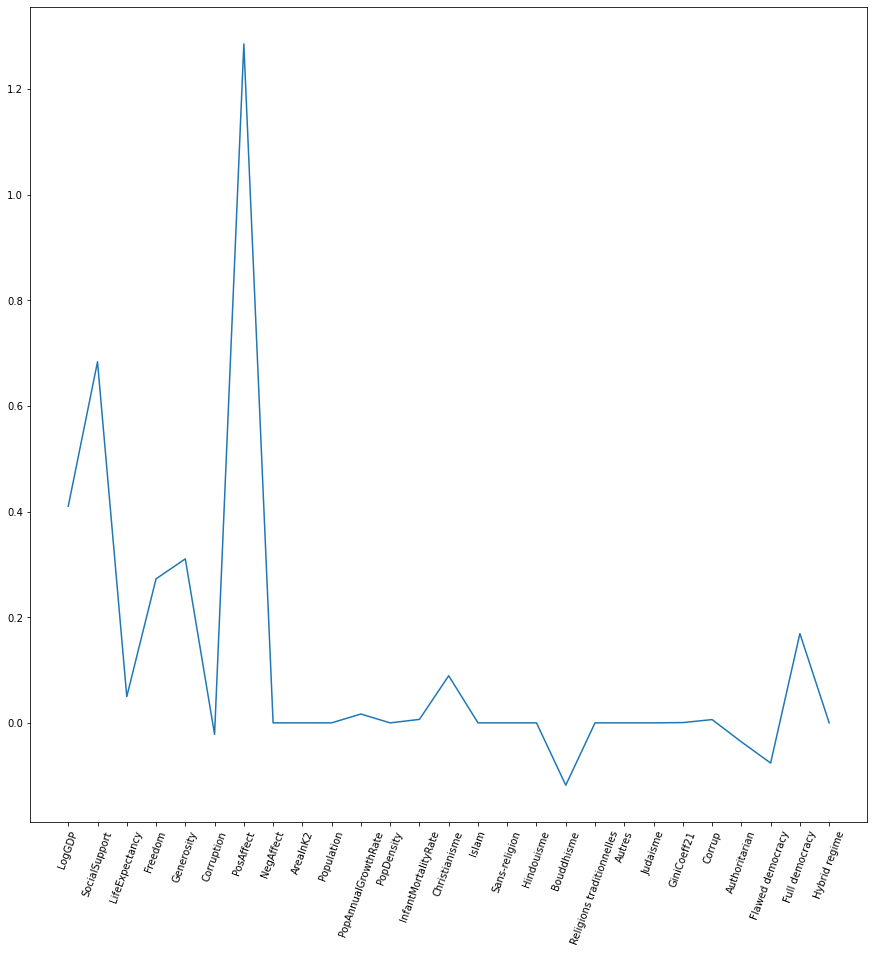

In [22]:
### Representation des coeffs pour chaque variable

plt.figure(figsize=(15,15))
plt.plot(range(len(whr_NoNA_all_lasso.columns)), clf_lasso_coef)
plt.xticks(range(len(whr_NoNA_all_lasso.columns)), whr_NoNA_all_lasso.columns.values, rotation=70);

On retrouve les varibles materielles comme le PIB qui ont de l'influence mais on a egalement le taux de mortalite infantile et les considerations de regimes politiques que l'on a ajouté et qui sont retenus

#### Performance du modele

In [23]:
print("le score sur le jeu d'entrainement est de : ",clf_lasso.score(X_train_lasso, y_train_lasso))


print("le score sur le jeu de test est de : ",clf_lasso.score(X_test_lasso, y_test_lasso))

le score sur le jeu d'entrainement est de :  0.7844665957556052
le score sur le jeu de test est de :  0.7395352805685251


On observe que le modele de regression lineaire regularisee de Lasso est celui qui peut permettre d'obtenir les meilleures performances. Une etude approfondie à l'aide de ce modele sera realisee plus tard.

Mais dans le prochain notebook nous allons tester les modeles sur des regions predefinies afin d'observer s'il y a des particularites regionales. Car au niveau mondial les variables comme le PIB restent prédominantes.